In [14]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.preprocessing import*
import datetime,time
from sklearn.metrics import*
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.decomposition import PCA

In [2]:
train_all_v1 = pd.read_csv('../../../../homecredit/train_all_v1.csv')

In [6]:
start_time = time.time()

obj_columns = train_all_v1 .select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
train_all_v1  = pd.get_dummies(train_all_v1 , columns = obj_columns, drop_first = True)

X= train_all_v1.drop(columns= ['Unnamed: 0','TARGET','SK_ID_CURR']).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = train_all_v1.TARGET


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=37)


end_time = time.time()  
execution_time = end_time - start_time
print("\n程式執行花費的時間：", round(execution_time,2), "秒")
print("done時間:", datetime.datetime.now())    


程式執行花費的時間： 0.64 秒
done時間: 2023-09-01 14:46:19.455152


In [7]:
start_time = time.time()

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

end_time = time.time()  
execution_time = end_time - start_time
print("\n程式執行花費的時間：", round(execution_time,2), "秒")
print("done時間:", datetime.datetime.now())  


程式執行花費的時間： 0.19 秒
done時間: 2023-09-01 14:46:33.637212


In [8]:
start_time = time.time()

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

end_time = time.time()  
execution_time = end_time - start_time
print("\n程式執行花費的時間：", round(execution_time,2), "秒")
print("done時間:", datetime.datetime.now()) 


程式執行花費的時間： 0.33 秒
done時間: 2023-09-01 14:47:03.089551


In [15]:
pca = PCA(n_components=0.95)  # 選擇解釋變異量為95%的主成分
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# 打印保留的主成分數量
print("保留的主成分數量:", pca.n_components_)

保留的主成分數量: 60


In [18]:
# obj_columns = train_all_v1 .select_dtypes(include=['object']).columns
# # Apply one-hot encoding to object columns
# train_all_v1  = pd.get_dummies(train_all_v1 , columns = obj_columns, drop_first = True)

# X= train_all_v1.drop(columns= ['Unnamed: 0','TARGET','SK_ID_CURR']).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# y = train_all_v1.TARGET


# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=37)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=37)



# data_dmatrix = lgb.Dataset(data=X_train,label=y_train)

In [23]:
params = {  'boosting_type':'gbdt','objective':"binary", 'is_unbalance':'True',  'metric': 'auc',
            'colsample_bytree':1.0,'importance_type':'split', 'learning_rate':0.1, 'max_depth':-1,
            'min_child_samples':20, 'min_child_weight':0.001, 'min_split_gain':0.0,
            'num_iteration':50, 'device':'gpu', 'num_leaves':31,'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True, 
            'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0,'verbosity':3}

# params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
#           'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 200, 'verbose': 0 ,
#           'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
#           'min_split_gain':.01, 'min_child_weight':1}



pipe_lgb = Pipeline([
    ('lgb', lgb.LGBMClassifier(**params))])

t0 = time.time()
pipe_lgb.fit(X_train_pca, y_train)
            #  lgb__eval_set=[(X_val.values, y_val.values)],  # 提供驗證集
            #  lgb__eval_names=['val', 'train'],  # 為驗證集命名
            #  lgb__eval_metric=['binary_logloss']      )# logloss  for lgbm classifier
t1 = time.time()

y_pred_prob = pipe_lgb.predict_proba(X_test_pca)[:, 1]


y_pred = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)  # 使用轉換後的二元預測
mse = mean_squared_error(y_test, y_pred_prob)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_prob)
r2 = r2_score(y_test, y_pred_prob)

print(f"ALL_AUC：{auc}")
print(f"ALL_ACC：{acc}")
print(f"ALL_MSE：{mse}")
print(f"ALL_RMSE：{rmse}")
print(f"ALL_MAE：{mae}")
print(f"ALL_R-squared：{r2}")
print('LightGBM GPU 版本耗時：{}'.format(t1 - t0))

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 60
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (15.84 MB) transferred to GPU in 0.026324 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431582
[LightGBM] [Info] Start training from score -2.431582
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[Li

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018782 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017125 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017748 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017021 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017117 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017686 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017784 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.016695 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017073 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017985 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017281 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017920 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018482 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017596 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017074 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017066 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.016439 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017989 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018414 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018742 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018205 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018532 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.016699 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018617 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018574 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017401 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018298 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.022420 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018344 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018676 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018236 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018061 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018355 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018106 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018170 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018352 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018015 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018064 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018138 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.019398 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018753 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018191 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017511 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018631 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018269 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017898 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017724 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.017828 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.018145 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

c:\Users\User\anaconda3\envs\Python39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874673
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 154
[LightGBM] [Info] Using GPU Device: Quadro P600, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (10.56 MB) transferred to GPU in 0.016234 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_iterations is set=50, num_iteration=50 will be ign

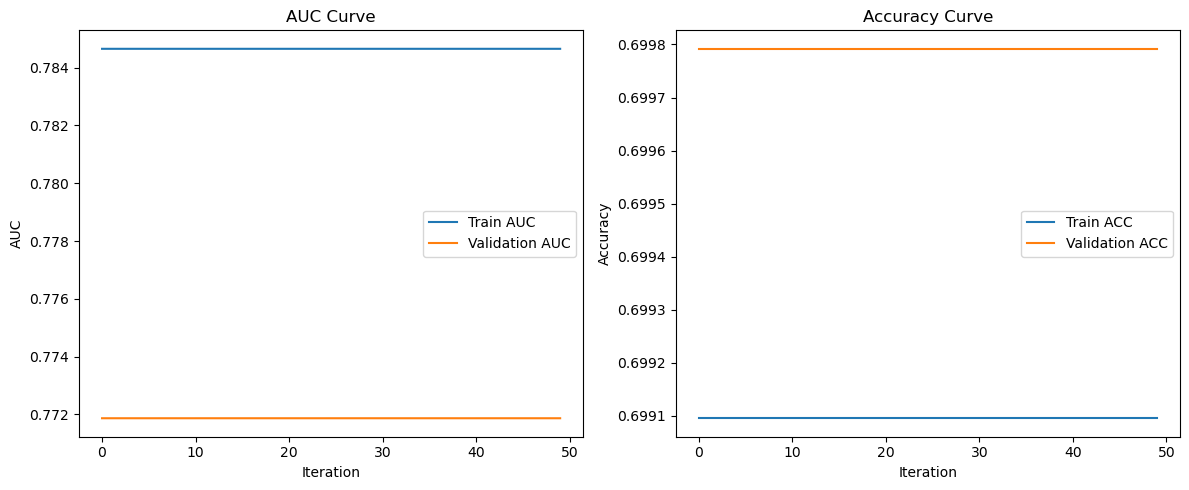

In [24]:
# 训练模型并记录AUC和ACC
train_auc_scores = []
train_acc_scores = []
val_auc_scores = []
val_acc_scores = []

pipe_lgb = lgb.LGBMClassifier(**params)
for iteration in range(params['num_iteration']):
    pipe_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    y_pred_prob_train = pipe_lgb.predict_proba(X_train)[:, 1]
    y_pred_prob_val = pipe_lgb.predict_proba(X_val)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_pred_prob_train)
    train_acc = accuracy_score(y_train, (y_pred_prob_train > 0.5).astype(int))
    val_auc = roc_auc_score(y_val, y_pred_prob_val)
    val_acc = accuracy_score(y_val, (y_pred_prob_val > 0.5).astype(int))
    
    train_auc_scores.append(train_auc)
    train_acc_scores.append(train_acc)
    val_auc_scores.append(val_auc)
    val_acc_scores.append(val_acc)
    
# 绘制AUC和ACC曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(params['num_iteration']), train_auc_scores, label='Train AUC')
plt.plot(range(params['num_iteration']), val_auc_scores, label='Validation AUC')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.title('AUC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(params['num_iteration']), train_acc_scores, label='Train ACC')
plt.plot(range(params['num_iteration']), val_acc_scores, label='Validation ACC')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

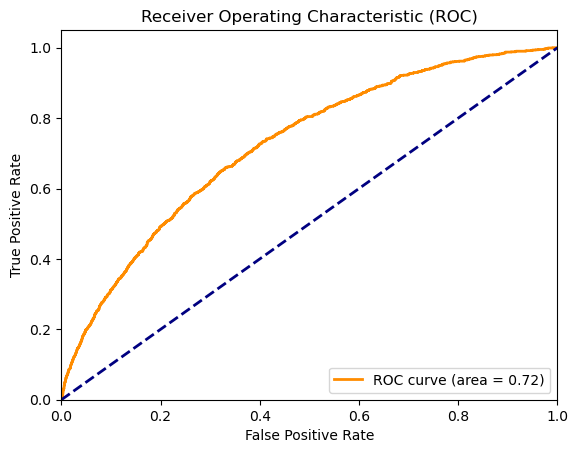

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 計算ROC曲線的偽陽性率、真陽性率和閾值
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 計算AUC值
roc_auc = auc(fpr, tpr)

# 繪製ROC曲線
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 使用LGBM模型的feature_importances_屬性獲取特徵重要性
feature_importances = pipe_lgb.named_steps['lgb'].feature_importances_

# 創建一個DataFrame來儲存特徵名稱和其重要性分數
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 將特徵按照重要性分數排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_features = importance_df.head(30)

# 使用seaborn的barplot繪製特徵重要性圖表
plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Importance', data=top_features)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


ValueError: All arrays must be of the same length

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0]) # 實際沒違約，預測正確
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0]) # 實際違約，預測卻沒有

Confusion matrix

 [[11403  2766]
 [  574   633]]

True Positives(TP) =  11403

True Negatives(TN) =  633

False Positives(FP) =  2766

False Negatives(FN) =  574


<Axes: >

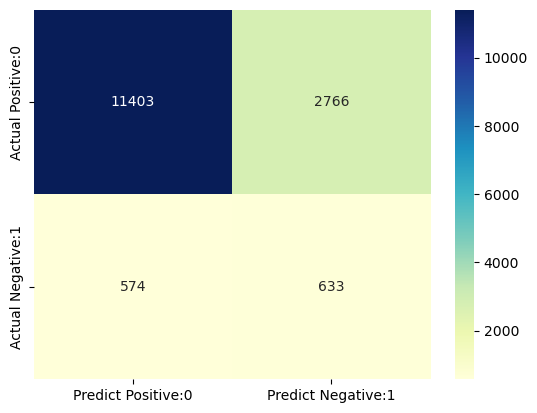

In [10]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28300
           1       1.00      0.00      0.00      2452

    accuracy                           0.92     30752
   macro avg       0.96      0.50      0.48     30752
weighted avg       0.93      0.92      0.88     30752

